Import Libraries

In [ ]:
import os
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.nnx as nnx
from flax import struct
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Any
import jraph
from itertools import combinations
import meshio
import numpy as np

Hyper Params

In [ ]:
Epochs = 500
alpha = 1.0 ; gamma = 1.0 ; lambda_ = 1.0
beta_1 = 0.999 ; beta_2 = 0.9
batch_size = 20
train_split = 0.9 ; CV_split = 0.05 ; test_split = 0.05
Learn_Rate = 0.001

RNG key

In [3]:
seed = 42 # This can be changed but is here to make the results easy to reproduce
base_key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(base_key)

Graph gen

In [4]:
def Get_known(boundary_points, points):
    is_known = jnp.zeros(points.shape[0]) 
    is_known = is_known.at[boundary_points].set(1)
    return is_known

def build_send_receive(cell):
    sender_array = []
    receiver_array = []
    for edge in combinations(cell,2):
        sender_array.append(edge[0])
        receiver_array.append(edge[1])
    return sender_array, receiver_array

def build_graphs(senders, receivers, positions, boundary_points, U) -> jraph.GraphsTuple:
    is_known = Get_known(boundary_points, positions)
    U_applied = jnp.zeros_like(U).at[boundary_points].set(U[boundary_points])
        
    node_features = jnp.concatenate([positions, U_applied, jnp.expand_dims(is_known, axis=1)], axis=1)
    num_nodes = positions.shape[0]

    graph = jraph.GraphsTuple(
        nodes=node_features,
        senders=senders,
        receivers=receivers,
        edges=None,
        globals=None, 
        n_node=jnp.array([num_nodes]),
        n_edge=jnp.array([len(senders)])
    )
    return graph

import data

In [5]:
# Define the path to your result file
filepath = os.path.join('data', 'vtk', 'u_final.vtu')

if not os.path.exists(filepath):
    print(f"Error: '{filepath}' not found. Please check the file path.")
else:
    mesh = meshio.read(filepath)

    positions = mesh.points
    right_face_indices = np.where(np.isclose(positions[:, 0], 1.0))[0]
    element_connectivity = mesh.cells[0].data

    unique_edges = set()

    for element in element_connectivity:
        element_senders, element_receivers = build_send_receive(element)
        
        for i in range(len(element_senders)):
            edge = tuple(sorted((element_senders[i], element_receivers[i])))
            unique_edges.add(edge)

    edge_list = jnp.array(list(unique_edges))
    senders = edge_list[:, 0]
    receivers = edge_list[:, 1]

    on_face_x0 = np.isclose(positions[:, 0], 0.0)
    on_face_x1 = np.isclose(positions[:, 0], 1.0)
    on_face_y0 = np.isclose(positions[:, 1], 0.0)
    on_face_y1 = np.isclose(positions[:, 1], 1.0)
    on_face_z0 = np.isclose(positions[:, 2], 0.0)
    on_face_z1 = np.isclose(positions[:, 2], 1.0)

    is_on_any_face = (on_face_x0 | on_face_x1 |
                      on_face_y0 | on_face_y1 |
                      on_face_z0 | on_face_z1)

    boundary_nodes = np.where(is_on_any_face)[0]

    print("Data extraction complete.\n")
    print(f"Positions array shape: {positions.shape}")
    print(f"Boundary indices array shape: {boundary_nodes.shape}")
    print(f"Senders array shape: {senders.shape}")
    print(f"Receivers array shape: {receivers.shape}")

Data extraction complete.

Positions array shape: (1331, 3)
Boundary indices array shape: (602,)
Senders array shape: (14230,)
Receivers array shape: (14230,)


Unpickling the data

In [6]:
import sys
import types
import pickle

fake_module = types.ModuleType("DataSetup")

class DataStore:
    def __init__(self):
        pass

fake_module.DataStore = DataStore

sys.modules["DataSetup"] = fake_module

data_file = r"/home/samuel/Github/Research-Placement/data/simulation_results.pkl"

try:
    with open(data_file, "rb") as f:
        data_unpickled_1 = pickle.load(f)
    print(f"Successfully unpickled data.")
except FileNotFoundError:
    print(f"Error: File not found at {data_file}")
    dataset_list = {}

dataset_dict = data_unpickled_1

# Not tunable, is known from how many sims ran
num_sims = 20000
# permutation list for batching
index_list = jnp.arange(num_sims)
permutated_index_list = jax.random.permutation(jax.random.PRNGKey(0), index_list)

Successfully unpickled data.


check data

In [7]:
print(dataset_dict[0]['boundary_strain_energy_gradient'].shape)
print(dataset_dict[0]['full_displacement_vector'].shape)
print(dataset_dict[0]['strain_energy'].shape)
print(dataset_dict[0]['applied_boundary_displacements'].shape)

print(dataset_dict[0]['boundary_strain_energy_gradient'])
print(dataset_dict[0]['full_displacement_vector'])
print(dataset_dict[0]['strain_energy'])

(1806, 3)
(1331, 3)
()
(1806, 3)
[[-2.9210228e-04 -6.3567061e-04 -1.4251155e-03]
 [-4.4415184e-04  8.9642766e-05 -6.0152575e-05]
 [-3.8378930e-04 -1.0108644e-04 -1.7809425e-05]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]
[[-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 [-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 [-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 ...
 [ 1.5876233e-03 -1.5465567e-04 -2.3625712e-03]
 [ 1.4152135e-03 -4.2626876e-04 -3.6217444e-04]
 [ 2.9660708e-03  7.4987329e-05  4.9074343e-03]]
0.004835612


Pre-processing functions - Need to be changed when preprocessing is implemented to accomodate the data format

In [ ]:
def mean_and_std_dev(data,*, train_split, permutated_idxs):
    split_idx = int(permutated_idxs.shape[0] * train_split)
    train_data = data[:split_idx, :]
    mean = jnp.mean(train_data, axis=0)
    std_dev = jnp.std(train_data, axis=0)
    return {'mean':mean, 'std_dev':std_dev}

def scale_data(data,*, data_params):
    return (data - data_params['mean']) / data_params['std_dev']
    
def unscale_data(data,*,data_params):
    return (data * data_params['std_dev']) + data_params['mean']

Data pre-processing and graph building

In [ ]:
processed_dataset_dict = dataset_dict

graphs_list = []
displacements_list = []
target_e_list = []
target_e_prime_list = []
boundary_displacements_list = []

# Graph Building
for i in tqdm(range(num_sims), leave=False):
    U = processed_dataset_dict[i]['full_displacement_vector']
    U = jnp.array(U)
    displacements_list.append(U)
    target_e = jnp.array(processed_dataset_dict[i]['strain_energy'])
    target_e_list.append(target_e)
    target_e_prime = jnp.array(processed_dataset_dict[i]['boundary_strain_energy_gradient'])
    target_e_prime_list.append(target_e_prime)
    bdd = jnp.array(processed_dataset_dict[i]['applied_boundary_displacements'])
    boundary_displacements_list.append(bdd)

boundary_displacements_array = jnp.stack(boundary_displacements_list) # (num_sims, nodes, displacement components)
target_e_array = jnp.stack(target_e_list) # (num_sims, value)
target_e_prime_array = jnp.stack(target_e_prime_list)
displacements_array = jnp.stack(displacements_list)

# Pre-processing
displacement_params = mean_and_std_dev(
    boundary_displacements_array, 
    train_split=train_split, 
    permutated_idxs=permutated_index_list
)

target_e_params = mean_and_std_dev(
    target_e_array, 
    train_split=train_split, 
    permutated_idxs=permutated_index_list
)

e_prime_params = mean_and_std_dev(
    target_e_prime_array, 
    train_split=train_split, 
    permutated_idxs=permutated_index_list
)

params_dict = {
    'displacements': displacement_params,
    'target_e': target_e_params,
    'target_e_prime': e_prime_params
}

graph = build_graphs(
        senders, 
        receivers, 
        positions, 
        boundary_nodes, 
        U
    )
graphs_list.append(graph)

dataset = {
    'graphs_list': graphs_list,
    'displacements': displacements_array,
    'target_e': target_e_array,
    'target_e_prime': target_e_prime_array,
    'boundary_displacements': boundary_displacements_array
}

Batching functions

In [10]:
def batch_and_split_dataset(dataset_dict, batch_size, train_split, CV_split, test_split, permutated_index_list):
    n_train_samples = int(train_split * permutated_index_list.shape[0]) 
    n_test_samples = int(test_split * permutated_index_list.shape[0]) 
    n_CV_samples = int(CV_split * permutated_index_list.shape[0]) 

    train_idx = list(permutated_index_list[:n_train_samples])
    test_idx = list(permutated_index_list[n_train_samples:(n_train_samples + n_test_samples)])
    CV_idx = list(permutated_index_list[(n_train_samples + n_test_samples):])

    def batch_indices(idx):  
        num_batches = len(idx) // batch_size
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            batch_idx = idx[start:end]
            
            graphs_in_batch = [dataset_dict['graphs_list'][i] for i in batch_idx]
            displacements_batch = [dataset_dict['displacements'][i] for i in batch_idx]
            e_batch = [dataset_dict['target_e'][i] for i in batch_idx]
            e_prime_batch = [dataset_dict['target_e_prime'][i] for i in batch_idx]

            batched_graphs = jraph.batch(graphs_in_batch)
            batched_displacements = jnp.array(displacements_batch)
            batched_e = jnp.array(e_batch)
            batched_e_prime = jnp.array(e_prime_batch)

            yield {
                'graphs': batched_graphs, 
                'displacements': batched_displacements, 
                'target_e': batched_e, 
                'target_e_prime': batched_e_prime
            }
    
    train_batches = list(batch_indices(train_idx))
    test_batches = list(batch_indices(test_idx))
    CV_batches = list(batch_indices(CV_idx))

    return train_batches, CV_batches, test_batches


Batching graphs

In [12]:
train_batches, CV_batches, test_batches = batch_and_split_dataset(
    dataset, 
    batch_size, 
    train_split, 
    CV_split, 
    test_split, 
    permutated_index_list
)

2025-08-28 19:34:26.227208: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 889.4KiB (rounded to 910848)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-28 19:34:26.310952: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************************************************************************************
E0828 19:34:26.311015 1840709 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 910720 bytes. [tf-allocator-allocation-error='']


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 910720 bytes.

Activation Functions

In [ ]:
def Silu(x: jax.Array) -> jax.Array:
    return x * nnx.sigmoid(x)

GAT Layer

In [ ]:
class GAT(nnx.Module):
    def __init__(self, in_features, out_features,*,rngs):
        key = rngs.params()
        initialiser = nnx.initializers.lecun_normal()
        self.W = nnx.Param(initialiser(key=key, shape=(in_features, out_features)))
        self.A = nnx.Param(initialiser(key=key, shape=(2 * out_features, 1)))

    def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:

        if graph.n_node is None:
            raise ValueError("GAT requires nodes to have features")
        
        h_sender = graph.nodes[graph.senders] @ self.W
        h_receiver = graph.nodes[graph.receivers] @ self.W

        send_receive_features = jnp.concatenate([h_sender, h_receiver], axis=-1)
        attention_scores = nnx.leaky_relu(send_receive_features @ self.A)
        
        attention_coefficients = jraph.segment_softmax(
            logits=attention_scores, 
            segments_ids=graph.receivers,
            num_segments=graph.n_node
        )

        weighted_features = attention_coefficients * h_sender

        aggregate_nodes = jraph.aggregate_edges_for_nodes(
            graph=graph,
            edge_features=weighted_features,
            aggregate_fn=jnp.sum
        )

        return graph._replace(nodes=aggregate_nodes)

SAGPool WIP

In [ ]:
class SAGPool(nnx.Module): 
    pass

Model

In [ ]:
class GNN(nnx.Module):
    def __init__(self, node_feature_dim: int, embedding_dim: int, output_dim: int, rngs: nnx.Rngs):
        self.embedding_layer = nnx.Linear(node_feature_dim, embedding_dim, rngs=rngs)
        self.decoding_layer = nnx.Linear(embedding_dim, output_dim, rngs=rngs)
        self.encoderL1 = GAT(embedding_dim, embedding_dim, rngs=rngs)
        self.BatchNormL1 = nnx.BatchNorm(num_features=embedding_dim, rngs=rngs)
        self.encoderL2 = GAT(embedding_dim, embedding_dim, rngs=rngs)
        self.BatchNormL2 = nnx.BatchNorm(num_features=embedding_dim, rngs=rngs)
        self.encoderL3 = GAT(embedding_dim, embedding_dim, rngs=rngs)
    
    def embedder(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        nodes = graph.nodes
        embeddings = self.embedding_layer(nodes)
        return graph._replace(nodes=embeddings)
    
    def apply_activation_and_res(self, graph: jraph.GraphsTuple, residual: jax.Array) -> jraph.GraphsTuple:
        nodes = graph.nodes
        activated_nodes = nnx.relu(nodes) + residual
        return graph._replace(nodes=activated_nodes)
    
    def apply_res(self, graph: jraph.GraphsTuple, residual: jax.Array):
        new_nodes = graph.nodes + residual
        return graph._replace(nodes=new_nodes)
        
    def decoder(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple: # Switch to SAGPool when its finished
        aggregate_nodes = jraph.aggregate_nodes(graph, jnp.sum)
        return self.decoding_layer(aggregate_nodes)
        
    def forward_pass(self, G: jraph.GraphsTuple, use_running_average: bool) -> jax.Array:
        G = self.embedder(G)
        res1 = G.nodes

        G = self.encoderL1(G)
        self.BatchNormL1.use_running_average = use_running_average
        nodes_norm = self.BatchNormL1(G.nodes)
        G = G._replace(nodes=nodes_norm)
        G = self.apply_activation_and_res(G, res1)
        res2 = G.nodes

        G = self.encoderL2(G)
        self.BatchNormL2.use_running_average = use_running_average
        nodes_norm = self.BatchNormL2(G.nodes)
        G = G._replace(nodes=nodes_norm)
        G = self.apply_activation_and_res(G, res2)
        res3 = G.nodes

        G = self.encoderL3(G)
        G = self.apply_res(G, res3)

        e = self.decoder(G)
        return e
    
    def __call__(self, G: jraph.GraphsTuple, use_running_average, boundary_nodes_idx):

        e = self.forward_pass(G, use_running_average)
        grad_graph = jax.grad(self.forward_pass, argnums=0)(G, use_running_average)
        e_prime = grad_graph.nodes[:,4:7]

        return e, e_prime

Loss function and Optimiser

In [ ]:
# Create Optimiser Instance
optimiser = optax.chain(
    optax.add_decayed_weights(weight_decay=1e-5),
    optax.adam(
        learning_rate=Learn_Rate, 
        b1=beta_1, 
        b2=beta_2
    )
)

def loss_fn(graph_batch, target_e, target_e_prime,*, Model, alpha, gamma, lam): 
    """
    Calculates the loss of a model, works to minimise the mean square error of both 
    the strain energy prediction and the strain energy derivative prediction,
    whilst forcing the function through zero.
    """
    
    prediction_e, prediction_e_prime = Model(graph_batch)
    loss_e = jnp.mean((prediction_e - target_e)**2)
    loss_e_prime = jnp.mean((prediction_e_prime - target_e_prime)**2)
    
    is_known = Get_known(boundary_nodes, positions)
    U_zero = jnp.zeros_like(positions)
    node_features = jnp.concatenate([positions, U_zero, is_known], axis=1)
    zero_graph = jraph.GraphsTuple(
        nodes=node_features,
        senders=senders,
        receivers=receivers,
        edges=None,
        globals=None, 
        n_node=jnp.array([positions.shape[0]]),
        n_edge=jnp.array([len(senders)])
    )
    
    prediction_zero, prediction_zero_prime = Model(zero_graph)
    target_e_prime_zero = jnp.zeros_like(target_e_prime[0])
    loss_zero = jnp.mean((prediction_zero - 0)**2) + jnp.mean(optax.huber_loss(prediction_zero_prime, target_e_prime_zero))


    return (alpha * loss_e + gamma * loss_e_prime + lam * loss_zero)

Training Dataclass

In [ ]:
class TrainState(nnx.Object):
    def __init__(self,params,graph_def,state):
        self.params = params
        self.graph_def = graph_def
        self.state = state

CV loss

In [ ]:
@jax.jit
def CV_loss_fn(CV_batches, graph_def, params, state, alpha, gamma, lambda_):
    Model = nnx.merge(graph_def, params, state)
    CV_loss = 0
    batch_count = 0

    for CV_batch in CV_batches:
        batch_count += 1
        graph_batch = CV_batch['graphs']
        target_e_batch = CV_batch['target_e']
        target_e_prime_batch = CV_batch['target_e_prime']

        loss = loss_fn(
            graph_batch,
            target_e_batch,
            target_e_prime_batch,
            Model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )

        CV_loss += loss

    if batch_count > 0:
        CV_loss = CV_loss / batch_count
        return CV_loss
    else:
        return 0

Train Step

In [ ]:
@jax.jit
def train_step(params, graph_def, state, opt_state, GraphandTarget_batch, *, alpha, gamma, lambda_):

    target_e_batch = GraphandTarget_batch['target_e']
    target_e_prime_batch = GraphandTarget_batch['target_e_prime']
    graph_batch = GraphandTarget_batch['graphs']

    def wrapped_loss(params_, state_):
        Model = nnx.merge(graph_def, params_, state_)
        loss = loss_fn(
            graph_batch,
            target_e_batch,
            target_e_prime_batch,
            Model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_ 
        )
        return loss
    
    loss, grads = nnx.value_and_grad(wrapped_loss, argnums=0)(params, state)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_state = state
    
    return new_params, new_state, new_opt_state, loss

Train Loop

In [ ]:
# Instantiate energy prediction NN
Model = GNN(
    node_feature_dim=7, 
    embedding_dim=128,
    output_dim=1,
    rngs=rngs
)

graph_def,params,state = nnx.split(Model,nnx.Param,nnx.BatchStat)
opt_state = optimiser.init(params)

train_state = TrainState(
    graph_def=graph_def,
    params=params,
    state=state
)

loss_record = []
CV_loss_record = []

for epoch in range(Epochs):
    running_loss = 0.0
    running_CV_loss = 0.0
    batch_count = 0
    for batch in tqdm(train_batches, desc=f"Epoch {epoch}/{Epochs}", leave=False):

        new_params, new_state, new_opt_state, batch_loss = train_step(
            train_state.params,
            train_state.graph_def,
            train_state.state,
            opt_state,
            batch,
            alpha=alpha,
            gamma=gamma,
            lambda_=lambda_
        )

        opt_state = new_opt_state
        train_state.params = new_params
        train_state.state = new_state

        batch_count += 1
        running_loss += batch_loss

    CV_loss = CV_loss_fn(
        CV_batches,
        train_state.graph_def,
        train_state.params,
        train_state.state,
        alpha,
        gamma,
        lambda_
    )
    
    loss_record.append(running_loss)
    CV_loss_record.append(CV_loss)


plot

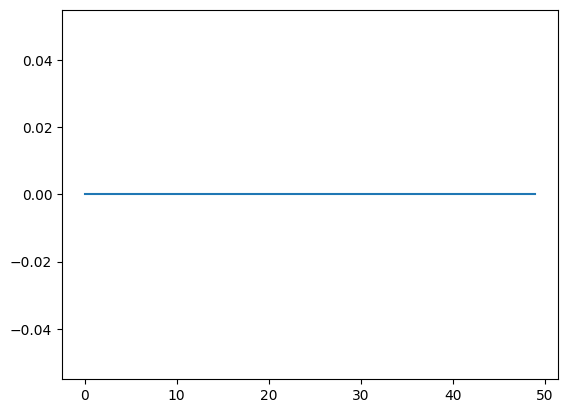

In [ ]:
plt.plot(loss_record)

Trained Model storage

In [ ]:
class Model_trained(nnx.Object):
    def __init__(self, params, graph_def, states):
        self.params = params
        self.graph_def = graph_def
        self.states = states